In [27]:
# Phu, Andrea and Watcher
# 2018 Spring

import torch
import torch.nn as nn
import torch.autograd as autograd
from torch.autograd import Variable
import torch.nn.functional as F
import torch.optim as optim
from torch import FloatTensor, LongTensor

import numpy as np
import pandas as pd
import time
import os
import pickle
import string
import torch.utils.data as data_utils
import psutil

torch.manual_seed(1)

In [28]:
def show_current_memory_usage():
    pid = os.getpid()
    py = psutil.Process(pid)
    mem_use_in_GB = py.memory_info().rss/(2**30)
    print("currently using",mem_use_in_GB,"GB memory!")

In [2]:
torch.__version__

'0.3.1.post2'

In [6]:
import nltk
# make sure you have the nltk resource downloaded
try:
    nltk.data.find('tokenizers/punkt')
except LookupError:
    print("no nltk resource, downloading now")
    nltk.download('punkt')

# Specify data paths for later use

In [123]:
# initialize data paths, so we can read data easily
ruling_data_path = '/data/Dropbox/Projects/originalism/data/BloombergVOTELEVEL_Touse.dta'
sentences_data_path = '/data/Dropbox/judge_embedding_data_sp18/sentences_data.csv'
cite_graph_path = '/data/Dropbox/Data/corpora/chen-cases/cite-graph/graph.zip'
judge_bio_data_path = '/data/Dropbox/Data/Judge-Bios/judgebios/JudgesBioReshaped_TOUSE.dta'
topic_data_path = '/data/Dropbox/Projects/Ash_Chen/metadata/bb2topic.pkl'
processed_data_path = '/data/Dropbox/judge_embedding_data_sp18'

merged_sentence_data_path = '/data/Dropbox/judge_embedding_data_sp18/sentence_topic_judgeid.csv'

meta_data_path = '/data/Dropbox/judge_embedding_data_sp18/circuit_metadata_excerpt.dta'
table_of_cases_path = '/data/Dropbox/judge_embedding_data_sp18/tableofcases'

judge_mapping_binary_filename = 'judgemap.pkl'

# currently using 6B 300d glove, this one has 400K vocab
glove_emb_path = '/data/Dropbox/judge_embedding_data_sp18/glove_files/glove.6B.300d.txt'
glove_binary_filename = 'glove6B300d.pkl'

opinion_sum_vector_final_merged_data_filename = 'opinion_sum_vec_final.pkl'
opinion_sum_vector_split_6_data_filename = 'opinion_sum_vec_split6.pkl'

pd.options.display.max_columns = 999

# first, read in the GloVe embeddings. If you did the processing already and have the glove binary, just read the binary it's faster

In [11]:

def get_glove_emb(glove_emb_path,verbose=0):
    # ONLY DO THIS IF YOU HAVEN'T DONE IT
    # this function takes the path to glove embedding txt file,
    # and give back 3 things:
    # the embedding in numpy matrix form
    # the word to index dictionary
    # the index to word dictionary
    
    starttime = time.time()
    # first open file
    glove_fpt = open(glove_emb_path,"r")
    # get first line
    line = glove_fpt.readline()
    word_index = 0
    list_of_vectors = []
    word2index = {} # this is used for converting word into an index
    index2word = {} # 
    while line:
#         if word_index == 1000: # DEBUGGING ONLY
#             break
        
        # print debugging info if verbose
        
        if verbose and word_index % 10000 == 0:
            print(word_index,time.time()-starttime)
        
        line = line.split()
        word = line[0]
        word2index[word] = word_index # here count 
        index2word[word_index] = word
        
        vector = [float(num) for num in line[1:]]
        list_of_vectors.append(vector)
        
        line = glove_fpt.readline()
        word_index += 1  
        
    emb_matrix = np.array(list_of_vectors)
    return emb_matrix, word2index, index2word
    
# glove_emb, word2index, index2word = get_glove_emb(glove_emb_path,verbose=1) # run this once

In [12]:
def dump_glove_to_binary_file(glove_emb, word2index, index2word,processed_data_path,save_filename):
    # use this to dump processed glove embedding to binary for faster use later
    # file name relative to processed data path
    with open(os.path.join(processed_data_path,save_filename),"wb") as f:  
        pickle.dump([glove_emb, word2index, index2word], f)

# dump_glove_to_binary_file(glove_emb, word2index, index2word,"glove6B300d.pkl") # run this once

def load_glove_binary(processed_data_path,save_filename):
    # after processed and saved glove binary, each time we use it we just load from the binary
    # file name relative to processed data path
    with open(os.path.join(processed_data_path,save_filename),"rb") as f:  
        glove_emb, word2index, index2word = pickle.load(f) 
    return glove_emb, word2index, index2word


In [13]:
glove_emb, word2index, index2word = load_glove_binary(processed_data_path,glove_binary_filename)

In [14]:
word2index["hello"]

13075

In [15]:
index2word[13075]

'hello'

6.4013519287109375

# now we have the glove embeddings, we can convert an opinion text into a vector representation

In [8]:
def read_merged_sentence_data(merged_sentence_data_path):
    # read merged sentence data, which should be in a csv file, use pandas
    merged_sentence_data = pd.read_csv(merged_sentence_data_path)
    return merged_sentence_data
    
merged_sentence_data_df = read_merged_sentence_data(merged_sentence_data_path)

In [9]:
merged_sentence_data_df

,caseid,year,middle_part,opinion_text,songername,judgeidentificationnumber,topic,geniss
0,XB0PMNQNB5G0,1891,contentMajOp,"p ardee , j., ( after stating the case .)\nth...","PARDEE, DON A.",1830.0,Civil Procedure,4.0
1,XFL757,1891,contentMajOp,"b rown , circuit justice, ( orally .)\nin thi...","BROWN, HENRY BILLINGS",284.0,Civil Procedure,4.0
2,XB0PMRQNB5G0,1891,contentMajOp,"p ardee , j. the case on this intervention is...","PARDEE, DON A.",1830.0,Contracts,7.0
3,XFL7KI,1891,contentMajOp,"l ocke , district judge.\nthis motion coming ...","LOCKE, JAMES WILLIAM",1410.0,Civil Procedure,4.0
4,XB0OI7QNB5G0,1891,contentMajOp,"n elson , j. this was an action brought to re...","NELSON, SUSAN RICHARD",3339.0,NaN,NaN
5,XB0PHFQNB5G0,1891,contentMajOp,"p ardee , j. the record shows a suit brought ...","PARDEE, DON A.",1830.0,Torts,7.0
6,XB0PJRQNB5G0,1891,contentMajOp,"b ruce , j. this is a suit brought in the cou...","BRUCE, JOHN",292.0,Corporate Law,7.0
7,XFL6PE,1891,contentMajOp,"b rown , circuit justice, ( orally .)\nin thi...","BROWN, HENRY BILLINGS",284.0,Civil Procedure,4.0
8,XFL6LS,1891,contentMajOp,"s age , district judge.\nthe suit is for the ...","SAGE, GEORGE READ",2089.0,Patent Law,7.0
9,XB0PNFQNB5G0,1891,contentMajOp,"p ardee , j. samuel w. groome filed an interv...","PARDEE, DON A.",1830.0,Mortgages & Liens,7.0


In [29]:
UNKNOWN_INDEX = 400000

def clean_sentence(sentence,delete_punc_table,word2index,unknown_index):
    # for each opinion text, we use this function to clean it up
    # first the punctuations are removed
    # then we tokenize it using nltk
    # then the first 10 words are removed because they might contain judge's name
    # and we don't want that in our data
    
    # then we will convert each word to an index
    # in our case this index dict comes from GloVe
    
    # define the table elsewhere so you don't define it everytime
    # delete_punc_table= str.maketrans("","",string.punctuation)
    sentence = sentence.translate(delete_punc_table) # remove punctuations
    tokens = nltk.word_tokenize(sentence) # tokenize
    tokens = tokens[10:] #remove first 10 words
    for i in range(len(tokens)):
        if tokens[i] in word2index:
            tokens[i] = word2index[tokens[i]]
        else:
            tokens[i] = unknown_index
    return tokens
    
def clean_all_sentences_in_merged(merged_df,word2index,UNKNOWN_INDEX,verbose=0):
    starttime = time.time()
    # this function takes in merged sentence data and changes 
    # all the opinion text to cleaned, list of index version
    n_entry = merged_df.shape[0]
    delete_punc_table= str.maketrans("","",string.punctuation)
    for i in range(n_entry):
        if verbose and i%10000==0:
            print(i,time.time()-starttime)
        
        sentence = merged_df.loc[i,'opinion_text']

        if len(sentence)==0: # report empty data entry
            print("no opinion data at entry:",i)
            continue
        
        merged_df.at[i,'opinion_text'] = clean_sentence(sentence,delete_punc_table,word2index,UNKNOWN_INDEX)
    return merged_df
    

In [30]:
merged_sentence_data_df = clean_all_sentences_in_merged(merged_sentence_data_df,word2index,UNKNOWN_INDEX,verbose=1)
merged_sentence_data_df

0 3.6716461181640625e-05
10000 88.07335567474365
20000 167.0551896095276
30000 232.19761610031128
40000 297.1047122478485
50000 368.68867540359497
60000 438.62476086616516
70000 508.1645758152008
80000 571.7696535587311
90000 636.5462205410004
100000 703.8432352542877
110000 770.4723958969116
120000 840.6470882892609
130000 921.3572702407837
140000 1009.6742203235626
150000 1103.4855470657349
160000 1202.1333651542664
170000 1303.517127752304
180000 1405.2191429138184
190000 1513.2608609199524
200000 1620.0603322982788
210000 1726.0602011680603
220000 1840.899932384491
230000 1958.3333139419556
240000 2080.1685066223145
250000 2208.5913746356964
260000 2354.405352115631
270000 2507.475908279419
280000 2667.332058429718
290000 2848.6277890205383


,caseid,year,middle_part,opinion_text,songername,judgeidentificationnumber,topic,geniss
0,XB0PMNQNB5G0,1891,contentMajOp,"[0, 202, 1268, 13, 0, 4600, 3, 0, 247954, 128,...","PARDEE, DON A.",1830.0,Civil Procedure,4.0
1,XFL757,1891,contentMajOp,"[15, 116, 4, 9238, 7, 22547, 3, 4092, 1219, 0,...","BROWN, HENRY BILLINGS",284.0,Civil Procedure,4.0
2,XB0PMRQNB5G0,1891,contentMajOp,"[215, 6, 68193, 3527, 255, 9670, 5, 12375, 3, ...","PARDEE, DON A.",1830.0,Contracts,7.0
3,XFL7KI,1891,contentMajOp,"[5, 0, 935, 4951, 5, 8151, 0, 4490, 3, 0, 305,...","LOCKE, JAMES WILLIAM",1410.0,Civil Procedure,4.0
4,XB0OI7QNB5G0,1891,contentMajOp,"[5214, 10, 894, 2091, 4297, 21, 0, 14485, 1268...","NELSON, SUSAN RICHARD",3339.0,NaN,NaN
5,XB0PHFQNB5G0,1891,contentMajOp,"[0, 377, 202, 3, 14963, 386, 92, 3, 745, 98, 0...","PARDEE, DON A.",1830.0,Torts,7.0
6,XB0PJRQNB5G0,1891,contentMajOp,"[202, 1268, 21, 0, 14485, 38, 14, 60389, 187, ...","BRUCE, JOHN",292.0,Corporate Law,7.0
7,XFL6PE,1891,contentMajOp,"[15, 116, 4, 18428, 0, 305, 4, 0, 1399, 202, 3...","BROWN, HENRY BILLINGS",284.0,Civil Procedure,4.0
8,XFL6LS,1891,contentMajOp,"[3, 133, 10550, 10, 1609, 400000, 0, 58, 84, 4...","SAGE, GEORGE READ",2089.0,Patent Law,7.0
9,XB0PNFQNB5G0,1891,contentMajOp,"[0, 2536, 3, 323, 1853, 128, 3, 50, 196, 7091,...","PARDEE, DON A.",1830.0,Mortgages & Liens,7.0


# Now we have processed the opinions into indexes and now we put the opinions into the LSTM or do an average of their embeddings to get vector representation of each opinion.

In [31]:
def get_average_embedding(merged_data_df,glove_emb,verbose=0):
    # when given all the opinions, in list of index form, this function will convert
    # each opinion into a fixed-sized vector representation
    starttime = time.time()
    
    vector_dim = glove_emb.shape[1] # this is likely 300
    
    n = merged_data_df.shape[0]
    embed_list = []
    
    number_words_in_embed = glove_emb.shape[0] # bigger than this means unknown word (index=400000)
    
    for i in range(n): # for n opinions
        if verbose and i%10000 == 0:
            print(i,time.time()-starttime)
        
        summed_emb = np.zeros(vector_dim)
        list_of_indexes = merged_data_df.loc[i,'opinion_text']
        m = len(list_of_indexes)
        for j in range(m):
            
            word_index = list_of_indexes[j]
            if word_index >= number_words_in_embed: # for this case, if seen unknown word, just ignore
                continue
            
            summed_emb += glove_emb[word_index,:]
        if m > 0:
            summed_emb /= m
        embed_list.append(summed_emb)
    return embed_list

In [32]:
embed_list = get_average_embedding(merged_sentence_data_df,glove_emb,verbose=1)

0 1.9311904907226562e-05
10000 28.483765363693237
20000 54.073904037475586
30000 76.00650215148926
40000 98.56668972969055
50000 123.60864496231079
60000 147.7259120941162
70000 171.76296615600586
80000 193.01146578788757
90000 214.56981539726257
100000 236.46879315376282
110000 258.6455421447754
120000 282.11643075942993
130000 308.42790722846985
140000 337.06641244888306
150000 367.49551463127136
160000 398.5945568084717
170000 431.0081298351288
180000 463.4004900455475
190000 497.1813268661499
200000 531.8459978103638
210000 566.0213072299957
220000 602.4564654827118
230000 639.7476959228516
240000 678.763156414032
250000 719.4256784915924
260000 762.0322606563568
270000 806.1991484165192
280000 853.0302352905273
290000 904.8321833610535


## Now we combine the opinion vectors with the merged dataset

In [33]:
merged_sentence_data_df['opinion_vector'] = 0
merged_sentence_data_df['opinion_vector'] = merged_sentence_data_df['opinion_vector'].astype(object)

In [34]:
for i in range(merged_sentence_data_df.shape[0]):
    merged_sentence_data_df.at[i,'opinion_vector'] = embed_list[i]

In [35]:
merged_sentence_data_df

,caseid,year,middle_part,opinion_text,songername,judgeidentificationnumber,topic,geniss,opinion_vector
0,XB0PMNQNB5G0,1891,contentMajOp,"[0, 202, 1268, 13, 0, 4600, 3, 0, 247954, 128,...","PARDEE, DON A.",1830.0,Civil Procedure,4.0,"[-0.07445931306292275, 0.05843820821632856, -0..."
1,XFL757,1891,contentMajOp,"[15, 116, 4, 9238, 7, 22547, 3, 4092, 1219, 0,...","BROWN, HENRY BILLINGS",284.0,Civil Procedure,4.0,"[-0.07101038203845275, 0.029874279749715626, -..."
2,XB0PMRQNB5G0,1891,contentMajOp,"[215, 6, 68193, 3527, 255, 9670, 5, 12375, 3, ...","PARDEE, DON A.",1830.0,Contracts,7.0,"[-0.059691082627907024, 0.10039284279069777, -..."
3,XFL7KI,1891,contentMajOp,"[5, 0, 935, 4951, 5, 8151, 0, 4490, 3, 0, 305,...","LOCKE, JAMES WILLIAM",1410.0,Civil Procedure,4.0,"[-0.13210430623456784, 0.12352108086419746, -0..."
4,XB0OI7QNB5G0,1891,contentMajOp,"[5214, 10, 894, 2091, 4297, 21, 0, 14485, 1268...","NELSON, SUSAN RICHARD",3339.0,NaN,NaN,"[-0.09034438144397865, 0.06449958495506274, -0..."
5,XB0PHFQNB5G0,1891,contentMajOp,"[0, 377, 202, 3, 14963, 386, 92, 3, 745, 98, 0...","PARDEE, DON A.",1830.0,Torts,7.0,"[-0.06601334912248623, 0.019215826325411318, -..."
6,XB0PJRQNB5G0,1891,contentMajOp,"[202, 1268, 21, 0, 14485, 38, 14, 60389, 187, ...","BRUCE, JOHN",292.0,Corporate Law,7.0,"[-0.11053901197255082, 0.10235485285668748, -0..."
7,XFL6PE,1891,contentMajOp,"[15, 116, 4, 18428, 0, 305, 4, 0, 1399, 202, 3...","BROWN, HENRY BILLINGS",284.0,Civil Procedure,4.0,"[-0.05526258051118215, 0.049538111821086264, -..."
8,XFL6LS,1891,contentMajOp,"[3, 133, 10550, 10, 1609, 400000, 0, 58, 84, 4...","SAGE, GEORGE READ",2089.0,Patent Law,7.0,"[-0.09545400352665524, 0.10511163229642662, -0..."
9,XB0PNFQNB5G0,1891,contentMajOp,"[0, 2536, 3, 323, 1853, 128, 3, 50, 196, 7091,...","PARDEE, DON A.",1830.0,Mortgages & Liens,7.0,"[-0.08174452291734276, 0.08172237472717521, -0..."


In [36]:
show_current_memory_usage()

currently using 7.554313659667969 GB memory!


## We need a mapping from judge id to judge embedding index. Judge id is given in the data, each judge id is unique to one judge, but judge id might not be something clean like 0 to a number.
## in our judge embedding, we need to convert judge_id to a index, this index basically indicate in the judge embedding matrix, which vector belongs to which judge

In [37]:
def get_judge_mappings(merged_sentence_data_df,verbose=0):
    n = merged_sentence_data_df.shape[0]
    index = 0
    index2judgeId = {}
    judgeId2Index = {}
    for i in range(n): # we are not using i as the index because one judge can have multiple cases
        if verbose==1 and i%10000==0:
            print(i)
        
        judge_id = int(merged_sentence_data_df.loc[i,'judgeidentificationnumber'])
        if judge_id not in judgeId2Index:
            index2judgeId[index] = judge_id
            judgeId2Index[judge_id] = index
            index += 1
    return index2judgeId,judgeId2Index

In [38]:
index2judgeId,judgeId2Index = get_judge_mappings(merged_sentence_data_df,verbose=1)

0
10000
20000
30000
40000
50000
60000
70000
80000
90000
100000
110000
120000
130000
140000
150000
160000
170000
180000
190000
200000
210000
220000
230000
240000
250000
260000
270000
280000
290000


In [39]:
print(len(index2judgeId),len(judgeId2Index))
number_judges = len(judgeId2Index)

2099 2099


In [41]:
def dump_judge_mapping(index2judgeId,judgeId2Index,processed_data_path,save_filename):
    with open(os.path.join(processed_data_path,save_filename),"wb") as f:  
        pickle.dump([index2judgeId, judgeId2Index], f)

# dump_judge_mapping(index2judgeId,judgeId2Index,processed_data_path,judge_mapping_binary_filename) # run this once
        
def load_judge_mapping(index2judgeId,judgeId2Index,processed_data_path,save_filename):
    with open(os.path.join(processed_data_path,save_filename),"rb") as f:  
        index2judgeId, judgeId2Index = pickle.load(f) 
    return index2judgeId, judgeId2Index


## we also need to put judge embed index into merged data df so it's easier for us to manage training code

In [42]:
merged_sentence_data_df['judge_embed_index'] = 0

In [43]:
for i in range(merged_sentence_data_df.shape[0]):
    judge_id = int(merged_sentence_data_df.at[i,'judgeidentificationnumber'])
    merged_sentence_data_df.at[i,'judge_embed_index'] = judgeId2Index[judge_id]


In [44]:
merged_sentence_data_df

,caseid,year,middle_part,opinion_text,songername,judgeidentificationnumber,topic,geniss,opinion_vector,judge_embed_index
0,XB0PMNQNB5G0,1891,contentMajOp,"[0, 202, 1268, 13, 0, 4600, 3, 0, 247954, 128,...","PARDEE, DON A.",1830.0,Civil Procedure,4.0,"[-0.07445931306292275, 0.05843820821632856, -0...",0
1,XFL757,1891,contentMajOp,"[15, 116, 4, 9238, 7, 22547, 3, 4092, 1219, 0,...","BROWN, HENRY BILLINGS",284.0,Civil Procedure,4.0,"[-0.07101038203845275, 0.029874279749715626, -...",1
2,XB0PMRQNB5G0,1891,contentMajOp,"[215, 6, 68193, 3527, 255, 9670, 5, 12375, 3, ...","PARDEE, DON A.",1830.0,Contracts,7.0,"[-0.059691082627907024, 0.10039284279069777, -...",0
3,XFL7KI,1891,contentMajOp,"[5, 0, 935, 4951, 5, 8151, 0, 4490, 3, 0, 305,...","LOCKE, JAMES WILLIAM",1410.0,Civil Procedure,4.0,"[-0.13210430623456784, 0.12352108086419746, -0...",2
4,XB0OI7QNB5G0,1891,contentMajOp,"[5214, 10, 894, 2091, 4297, 21, 0, 14485, 1268...","NELSON, SUSAN RICHARD",3339.0,NaN,NaN,"[-0.09034438144397865, 0.06449958495506274, -0...",3
5,XB0PHFQNB5G0,1891,contentMajOp,"[0, 377, 202, 3, 14963, 386, 92, 3, 745, 98, 0...","PARDEE, DON A.",1830.0,Torts,7.0,"[-0.06601334912248623, 0.019215826325411318, -...",0
6,XB0PJRQNB5G0,1891,contentMajOp,"[202, 1268, 21, 0, 14485, 38, 14, 60389, 187, ...","BRUCE, JOHN",292.0,Corporate Law,7.0,"[-0.11053901197255082, 0.10235485285668748, -0...",4
7,XFL6PE,1891,contentMajOp,"[15, 116, 4, 18428, 0, 305, 4, 0, 1399, 202, 3...","BROWN, HENRY BILLINGS",284.0,Civil Procedure,4.0,"[-0.05526258051118215, 0.049538111821086264, -...",1
8,XFL6LS,1891,contentMajOp,"[3, 133, 10550, 10, 1609, 400000, 0, 58, 84, 4...","SAGE, GEORGE READ",2089.0,Patent Law,7.0,"[-0.09545400352665524, 0.10511163229642662, -0...",5
9,XB0PNFQNB5G0,1891,contentMajOp,"[0, 2536, 3, 323, 1853, 128, 3, 50, 196, 7091,...","PARDEE, DON A.",1830.0,Mortgages & Liens,7.0,"[-0.08174452291734276, 0.08172237472717521, -0...",0


# It takes a lot of time to process the data so again we should save the finished data to a binary so that we can easily use later. 

In [46]:
## run this once
# merged_sentence_data_df.to_pickle(os.path.join(processed_data_path,opinion_sum_vector_final_merged_data_filename))

In [47]:
show_current_memory_usage()

currently using 7.6067657470703125 GB memory!


## Now we should do the train-val-test split, we first sort by judge_id, then for each judge we take a certain ratio of his/her cases and do the split.

In [86]:
from sklearn.utils import shuffle
def train_val_test_split(data_df,number_judges,train_ratio=0.8,val_ratio=0.1,verbose=0):
    # the input is the processed data
    # first we sort it by judge embed index, this might make life easier for the split
    # NOTE HERE THE DATA IS NOT SHUFFLED, SO LATER WE NEED TO SHUFFLE EACH DATASET
    starttime= time.time()
    
    sorted_all_data = data_df.sort_values(by='judge_embed_index')
    train_df = pd.DataFrame()
    val_df = pd.DataFrame()
    test_df = pd.DataFrame() 
    for index in range(number_judges):
        if verbose and index%10 == 0:
            print(index,time.time()-starttime)
        
        cases_of_this_judge = sorted_all_data.loc[sorted_all_data['judge_embed_index'] == index]
        shuffled_cases = shuffle(cases_of_this_judge) # we need it to be shuffled
        
        num_cases = shuffled_cases.shape[0]
        n_of_train = int(num_cases*train_ratio)
        n_of_val = int(num_cases*val_ratio)

        train_df = train_df.append(shuffled_cases.iloc[:n_of_train,:])
        val_df = val_df.append(shuffled_cases.iloc[n_of_train:n_of_train+n_of_val,:])
        test_df = test_df.append(shuffled_cases.iloc[n_of_train+n_of_val:,:])
    return train_df, val_df, test_df

In [87]:
train_df, val_df, test_df = train_val_test_split(merged_sentence_data_df,number_judges,verbose=1)


0 0.06509232521057129
10 0.17598390579223633
20 0.3119027614593506
30 0.4348142147064209
40 0.567054033279419
50 0.6975250244140625
60 0.8312900066375732
70 0.9752330780029297
80 1.1195716857910156
90 1.262904405593872
100 1.4233779907226562
110 1.5720608234405518
120 1.7438595294952393
130 1.9108233451843262
140 2.0760538578033447
150 2.273524761199951
160 2.4683220386505127
170 2.6827940940856934
180 2.897587537765503
190 3.1246676445007324
200 3.3543076515197754
210 3.630739450454712
220 3.9152610301971436
230 4.162958383560181
240 4.449813365936279
250 4.73879861831665
260 5.012322664260864
270 5.294454097747803
280 5.632459878921509
290 5.945668458938599
300 6.315958738327026
310 6.70392370223999
320 7.0502142906188965
330 7.4499266147613525
340 7.841948509216309
350 8.261646509170532
360 8.646233558654785
370 9.11572790145874
380 9.514394998550415
390 9.9029061794281
400 10.32972526550293
410 10.817571878433228
420 11.266073226928711
430 11.772482872009277
440 12.252471446990967


In [88]:
print(train_df.shape[0] + val_df.shape[0]+test_df.shape[0],merged_sentence_data_df.shape[0]) # should be the same
show_current_memory_usage()

295491 295491
currently using 7.775646209716797 GB memory!


# Now we have everything we need to feed into a neural net. For each data entry, we will first concatenate the opinion vector with other things.
# But for testing purposes, right now we just use the opinion vector to train judge embeddings. 

In [120]:
def df_to_Tensor(df,feature_dim=300,toshuffle=True):
    # use this to convert a dataframe to torch tensor,
    # the features are currently opinion vector only
    if toshuffle:
        df_to_use = shuffle(df)
    else:
        df_to_use = df
    
    X = np.zeros((df_to_use.shape[0],feature_dim))
    
    opinion_vectors = df_to_use['opinion_vector'].as_matrix()
    
    for i in range(df_to_use.shape[0]):
        X[i,:] = opinion_vectors[i]
    y = df_to_use['judge_embed_index'].as_matrix()
    return FloatTensor(X),LongTensor(y)
    

In [124]:
X_train, y_train = df_to_Tensor(train_df)
X_val, y_val = df_to_Tensor(val_df)
X_test, y_test = df_to_Tensor(test_df)

split_vector_sum_data = [X_train,y_train,X_val,y_val,X_test,y_test]

def dump_general_data(somedata,processed_data_path,save_filename):
    with open(os.path.join(processed_data_path,save_filename),"wb") as f:  
        pickle.dump(somedata, f)
        
def load_general_data(processed_data_path,save_filename):
    with open(os.path.join(processed_data_path,save_filename),"rb") as f:  
        return pickle.load(f)
        
## do this once
# dump_general_data(split_vector_sum_data,processed_data_path,opinion_sum_vector_split_6_data_filename)

In [125]:
show_current_memory_usage()

currently using 8.839691162109375 GB memory!


# The data is fully prepared, in 6 separate tensors, now we need a pytorch dataset and a dataloader for the training set.

In [185]:
BATCH_SIZE = 64
train_dataset = data_utils.TensorDataset(data_tensor=X_train,target_tensor=y_train)
train_loader = data_utils.DataLoader(dataset=train_dataset,batch_size=BATCH_SIZE,shuffle=True)


In [208]:
class Judge_emb_model(nn.Module):
    def __init__(self, input_dim, hidden_layer_dim, embedding_dim, num_judges):
        super(Judge_emb_model,self).__init__()
        # input is m x D
        self.linear1 = nn.Linear(input_dim,hidden_layer_dim) # D x H 
        self.dropout1 = nn.Dropout(p=0.5)
        self.linear2 = nn.Linear(hidden_layer_dim,hidden_layer_dim) # H x H
        self.dropout2 = nn.Dropout(p=0.5)
        self.linear3 = nn.Linear(hidden_layer_dim,embedding_dim)
        self.dropout3 = nn.Dropout(p=0.5)
        
        self.judge_embedding = nn.Linear(embedding_dim,num_judges) # H x J
        # the output is m x J
        
        self.init_weights()

    def forward(self, X):
        out = F.relu(self.linear1(X))
        out = self.dropout1(out)
        out = F.relu(self.linear2(out))
        out = self.dropout2(out)
        out = F.relu(self.linear3(out))
        out = self.judge_embedding(out)
        
        # now we have m x J matrix, for m data points, we can do log softmax
        log_prob = F.log_softmax(out,dim=1)
        return log_prob # for each opinion data, this is probability of which judge writes this opinion
    
    def init_weights(self):
        linear_layers = [self.linear1,self.linear2,self.linear3,self.judge_embedding]
        for layer in linear_layers:
            layer.weight.data.normal_(0.0,0.1)


In [209]:

INPUT_DIM = 300
HIDDEN_DIM = 500
EMBED_DIM = 500

model = Judge_emb_model(input_dim=INPUT_DIM,hidden_layer_dim=HIDDEN_DIM,embedding_dim=EMBED_DIM,num_judges=number_judges)

In [210]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(),lr=0.01)

In [211]:
N_EPOCH = 20
TRAIN_SIZE = train_dataset.data_tensor.shape[0]
print("Training data size",TRAIN_SIZE)
train_losses = []
val_losses = []


X_val_var = Variable(X_val)
y_val_var = Variable(y_val)
model.eval()
y_pred_val = model.forward(X_val_var)
val_loss = criterion(y_pred_val,y_val_var)
print("initial val loss",val_loss.data[0])
startTime = time.time()

for i_epoch in range(N_EPOCH):
    epoch_train_loss = 0
    num_batches_per_epoch = int(TRAIN_SIZE/BATCH_SIZE)
    for i_batch,(X_batch, y_batch) in enumerate(train_loader):
        optimizer.zero_grad()
        
        X_var, y_var = Variable(X_batch),Variable(y_batch)
        
        y_pred = model.forward(X_var)
        loss = criterion(y_pred,y_var)
        loss.backward()
        
        optimizer.step()
#         if i_batch % 2000 == 0:
#             print(i_epoch,i_batch,loss.data[0])
        epoch_train_loss += loss.data[0]
        
    # after each epoch
    
    X_val_var = Variable(X_val)
    y_val_var = Variable(y_val)
    model.eval()
    y_pred_val = model.forward(X_val_var)
    val_loss = criterion(y_pred_val,y_val_var)
    ave_train_loss = epoch_train_loss/num_batches_per_epoch
    print("epoch",i_epoch,"ave_train_loss",
          ave_train_loss,"validation loss:",val_loss.data[0],time.time()-startTime)
    val_losses.append(val_loss.data[0])
    train_losses.append(ave_train_loss)
    model.train()
    

Training data size 235443
initial val loss 8.143644332885742
epoch 0 ave_train_loss 5.6878217757558485 validation loss: 5.401882648468018 388.97240924835205
epoch 1 ave_train_loss 5.563054643291828 validation loss: 5.366166114807129 839.2582097053528
epoch 2 ave_train_loss 5.406814764607789 validation loss: 5.3386735916137695 1298.2774350643158
epoch 3 ave_train_loss 5.385076366863282 validation loss: 5.379945755004883 1768.2599503993988
epoch 4 ave_train_loss 5.378563823876269 validation loss: 5.320034027099609 2236.5813245773315


KeyboardInterrupt: 

In [212]:
result_embeddings = model.judge_embedding.weight.data.numpy()

In [213]:
result_embeddings.shape

(2099, 500)

In [214]:
## here we want the judge circuit number so we can color the 
judge_decision_path = '/data/Dropbox/judge_embedding_data_sp18/judge_decision.csv'
judge_decision_df = pd.read_csv(judge_decision_path)
judge_decision_df

,caseid,Circuit,date,songername,affirmdummy,judge_decision
0,X10284I003,4,2004-03-31,"LUTTIG, J. MICHAEL",0.0,0
1,X10284I003,4,2004-03-31,"WILKINSON, J. HARVIE, III",0.0,0
2,X10284I003,4,2004-03-31,"TRAXLER, WILLIAM BYRD, JR.",0.0,0
3,X102UPO003,3,2004-04-05,"RENDELL, MARJORIE O.",0.0,0
4,X102UPO003,3,2004-04-05,"SLOVITER, DOLORES K.",0.0,0
5,X102UPO003,3,2004-04-05,"ALDISERT, RUGGERO",0.0,0
6,X1037E8N,6,1989-08-31,"CONTIE, LEROY J.",0.0,0
7,X1037E8N,6,1989-08-31,"RYAN, JAMES L.",0.0,0
8,X1037E8N,6,1989-08-31,"WELLFORD, HARRY W.",0.0,0
9,X1037H8N,3,1993-06-11,"HUTCHINSON, WILLIAM D.",0.0,0


In [215]:
merged_sentence_data_df

,caseid,year,middle_part,opinion_text,songername,judgeidentificationnumber,topic,geniss,opinion_vector,judge_embed_index
0,XB0PMNQNB5G0,1891,contentMajOp,"[0, 202, 1268, 13, 0, 4600, 3, 0, 247954, 128,...","PARDEE, DON A.",1830.0,Civil Procedure,4.0,"[-0.07445931306292275, 0.05843820821632856, -0...",0
1,XFL757,1891,contentMajOp,"[15, 116, 4, 9238, 7, 22547, 3, 4092, 1219, 0,...","BROWN, HENRY BILLINGS",284.0,Civil Procedure,4.0,"[-0.07101038203845275, 0.029874279749715626, -...",1
2,XB0PMRQNB5G0,1891,contentMajOp,"[215, 6, 68193, 3527, 255, 9670, 5, 12375, 3, ...","PARDEE, DON A.",1830.0,Contracts,7.0,"[-0.059691082627907024, 0.10039284279069777, -...",0
3,XFL7KI,1891,contentMajOp,"[5, 0, 935, 4951, 5, 8151, 0, 4490, 3, 0, 305,...","LOCKE, JAMES WILLIAM",1410.0,Civil Procedure,4.0,"[-0.13210430623456784, 0.12352108086419746, -0...",2
4,XB0OI7QNB5G0,1891,contentMajOp,"[5214, 10, 894, 2091, 4297, 21, 0, 14485, 1268...","NELSON, SUSAN RICHARD",3339.0,NaN,NaN,"[-0.09034438144397865, 0.06449958495506274, -0...",3
5,XB0PHFQNB5G0,1891,contentMajOp,"[0, 377, 202, 3, 14963, 386, 92, 3, 745, 98, 0...","PARDEE, DON A.",1830.0,Torts,7.0,"[-0.06601334912248623, 0.019215826325411318, -...",0
6,XB0PJRQNB5G0,1891,contentMajOp,"[202, 1268, 21, 0, 14485, 38, 14, 60389, 187, ...","BRUCE, JOHN",292.0,Corporate Law,7.0,"[-0.11053901197255082, 0.10235485285668748, -0...",4
7,XFL6PE,1891,contentMajOp,"[15, 116, 4, 18428, 0, 305, 4, 0, 1399, 202, 3...","BROWN, HENRY BILLINGS",284.0,Civil Procedure,4.0,"[-0.05526258051118215, 0.049538111821086264, -...",1
8,XFL6LS,1891,contentMajOp,"[3, 133, 10550, 10, 1609, 400000, 0, 58, 84, 4...","SAGE, GEORGE READ",2089.0,Patent Law,7.0,"[-0.09545400352665524, 0.10511163229642662, -0...",5
9,XB0PNFQNB5G0,1891,contentMajOp,"[0, 2536, 3, 323, 1853, 128, 3, 50, 196, 7091,...","PARDEE, DON A.",1830.0,Mortgages & Liens,7.0,"[-0.08174452291734276, 0.08172237472717521, -0...",0


In [216]:
def get_judge_name2Index(merged_sentence_data_df,verbose=0):
    n = merged_sentence_data_df.shape[0]
    index2songerName = {}
    songerName2Index = {}
    for i in range(n): # we are not using i as the index because one judge can have multiple cases
        if verbose==1 and i%10000==0:
            print(i)
        judge_index = merged_sentence_data_df.loc[i,'judge_embed_index']
        songer_name =  merged_sentence_data_df.loc[i,'songername']
        
        if judge_index not in index2songerName:
            index2songerName[judge_index] = songer_name
            songerName2Index[songer_name] = judge_index
            
    return index2songerName,songerName2Index

index2songerName,songerName2Index  = get_judge_name2Index(merged_sentence_data_df)

In [217]:
index2songerName[0]

'PARDEE, DON A.'

In [220]:
judgeIndex2Circuit = {} # maps a judge's index to the circuit he belongs to

for i in range(judge_decision_df.shape[0]):
    songername = judge_decision_df.loc[i,'songername']
    if songername not in songerName2Index:
        continue
    judgeIndex = songerName2Index[songername]
    if judgeIndex not in judgeIndex2Circuit:
        judgeIndex2Circuit[judgeIndex] = judge_decision_df.loc[i,'Circuit']
        
judgeIndex2Circuit[0]

5

In [223]:
print(songerName2Index["LUTTIG, J. MICHAEL"])

1580


In [224]:
print(judgeIndex2Circuit[1580])

4


In [161]:
import matplotlib.pyplot as plt


## Plot the validation loss w.r.t. epoches

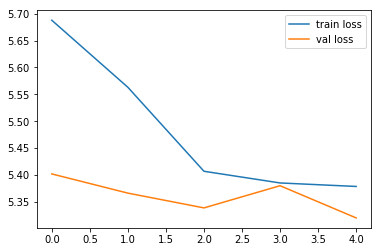

In [249]:
plt.plot(np.arange(len(train_losses)),train_losses,label="train loss")
plt.plot(np.arange(len(val_losses)),val_losses,label="val loss")
plt.legend()

## Get embedding from model and visualize it

In [231]:
train_emb = model.judge_embedding.weight.data

In [232]:
train_emb.shape

torch.Size([2099, 500])

In [252]:
trained_embedding_all = dict()

In [253]:
circuit_column = np.zeros(2099)
for i in range(2099):
    circuit_column[i] = judgeIndex2Circuit[i]

trained_embedding_all["embedding"] = train_emb
trained_embedding_all["circuit"] = circuit_column


In [254]:
## save this to file for later usage
dump_general_data(trained_embedding_all,processed_data_path,"trained_embedding_0.pkl")

In [233]:
from sklearn.decomposition import PCA

pca = PCA(n_components=3)
pca_result = pca.fit_transform(train_emb)

In [234]:
pca_result.shape

(2099, 3)

In [235]:
pca.explained_variance_ratio_

array([0.16741362, 0.14752164, 0.09414945])

In [236]:
import matplotlib.pyplot as plt


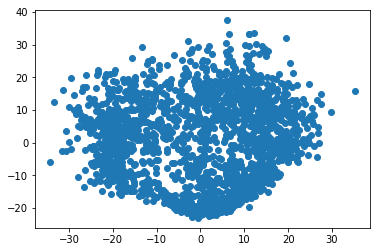

In [237]:
plt.scatter(pca_result[:,0],pca_result[:,1])

In [238]:
import time

from sklearn.manifold import TSNE

In [239]:
time_start = time.time()
tsne = TSNE(n_components=2, verbose=1, perplexity=40, n_iter=600)
tsne_results = tsne.fit_transform(train_emb)

[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 2099 samples in 0.021s...
[t-SNE] Computed neighbors for 2099 samples in 3.624s...
[t-SNE] Computed conditional probabilities for sample 1000 / 2099
[t-SNE] Computed conditional probabilities for sample 2000 / 2099
[t-SNE] Computed conditional probabilities for sample 2099 / 2099
[t-SNE] Mean sigma: 4.387543
[t-SNE] KL divergence after 250 iterations with early exaggeration: 67.927155
[t-SNE] Error after 600 iterations: 0.953851


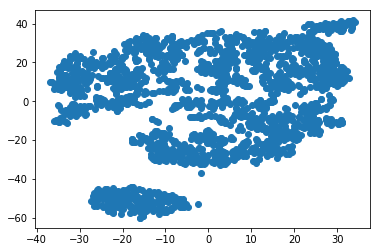

In [240]:
plt.scatter(tsne_results[:,0],tsne_results[:,1])

## now we first do PCA and then use tSNE

In [241]:
pca_50 = PCA(n_components=50)
pca_result_50 = pca_50.fit_transform(train_emb)

In [242]:
pca_result_50.shape

(2099, 50)

In [256]:
time_start = time.time()
tsne = TSNE(n_components=2, verbose=1, perplexity=10, n_iter=1000)
tsne_results = tsne.fit_transform(pca_result_50)

[t-SNE] Computing 31 nearest neighbors...
[t-SNE] Indexed 2099 samples in 0.003s...
[t-SNE] Computed neighbors for 2099 samples in 0.335s...
[t-SNE] Computed conditional probabilities for sample 1000 / 2099
[t-SNE] Computed conditional probabilities for sample 2000 / 2099
[t-SNE] Computed conditional probabilities for sample 2099 / 2099
[t-SNE] Mean sigma: 2.677620
[t-SNE] KL divergence after 250 iterations with early exaggeration: 75.510529
[t-SNE] Error after 1000 iterations: 1.077092


In [246]:
colors = ['b','g','r','c','m','y','k','b','g','r','c','m','y','k']
color_seq = []
for i in range(2099):
    colorIndex = judgeIndex2Circuit[i]
    if colorIndex < 14:
        color_seq.append(colors[colorIndex])
    else:
        color_seq.append('b')



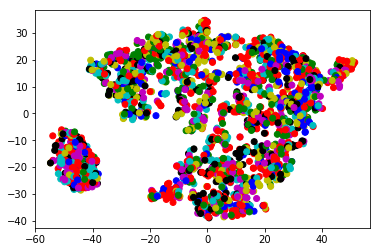

In [247]:
plt.scatter(tsne_results[:,0],tsne_results[:,1],c=color_seq)

In [ ]:
judgeIndex2Circuit

## Save the model to disk

In [165]:
# torch.save(model,"prototype_1.h5")


/usr/local/anaconda/anaconda3/lib/python3.6/site-packages/torch/serialization.py:159: UserWarning: Couldn't retrieve source code for container of type Judge_emb_model. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
